**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso:** Electiva Aprendizaje Automático

**Segundo Semestre 2025**

**Profesor:** Dr. Luis-Alexander Calvo-Valverde

---

**Trabajo Práctico:** 1

**Datos de la entrega:** Jueves 2 de octubre 2025, a más tardar a las 6:00 pm.

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo jupyter (`.ipynb`) y todos los archivos adicionales que se requieran para correr su cuaderno (en un archivo comprimido).

---

**Estudiantes:**
- David Alberto Guevara Sánchez
- Kenneth Barboza Corrales

# Favor leer esto primero.

1. Se le adjunta material sobre Series Temporales en PDF, debe estudiarlo antes de proceder con la solución del presente Trabajo Práctico. Se adjuntan los archivos `.csv` requeridos por si desea probar el código de dicho material. El código que incluye el material podría requerir alguna modificación por su parte, esto por el conocido proceso de actualización de las bibliotecas.

2. Usted puede cambiar los archivos de series temporales que se le proporcionan por otras series temporales que sean de su interés; pero de hacerlo, se le recomienda valorarlo con el profesor para que sus series temporales no le agreguen una complicación importante al Trabajo Práctico.

# Parte 1.  Series temporales y graficación (35 puntos)

1. **Utilizando el archivo la serie temporal en el archivo: `TS_d_1`**, realice la presente sección.
2. Complete en celdas de código y/o texto según convenga.
3. Documente bien su código.

In [2]:
from __future__ import annotations

import math
from typing import Any, cast

import matplotlib.pyplot as plt
import pandas as pd
from pandas import DatetimeIndex, Series
from pandas.plotting import lag_plot
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

### 1.1
- Cargue el archivo.
- Muestre los cinco primeros registros.
- Muestre qué tipo de datos es la variable series

In [3]:
df1 = pd.read_csv("./data/TS_d_1.csv", index_col=0).iloc[:, 0].astype("float64")
df1.index = pd.to_datetime(df1.index, format="%d/%m/%Y")
df1.head(5)

fecha
2004-01-01    5.3
2004-01-02    5.6
2004-01-03    5.9
2004-01-04    6.2
2004-01-05    8.4
Name: temperatura, dtype: float64

In [4]:
type(df1)

pandas.core.series.Series

### 1.2
- Muestra el promedio, la mediana y la desviación estándar de los datos

In [5]:
print(f"""
promedio: {df1.mean():.3f}
mediana: {df1.median():.3f}
varianza: {df1.var():.3f}
desviación estandar: {df1.std():.3f}
""")


promedio: 8.014
mediana: 7.400
varianza: 14.930
desviación estandar: 3.864



### 1.3
- Muestre el promedio para cada uno de los meses del año. Es decir, el promedio para todos los Eneros, luego el promedio para todos los Febreros, y así sucesivamente.

In [6]:
monthly_avg = df1.groupby(df1.index.month).mean().reindex(range(1, 12 + 1))
monthly_avg.index = pd.date_range("2000-01-01", periods=12, freq="MS").month_name(locale="es_ES")

for month, avg_temp in monthly_avg.items():
    print(f"{month}: {avg_temp:.4f} °C")

Enero: 7.6881 °C
Febrero: 7.7358 °C
Marzo: 7.8743 °C
Abril: 8.5248 °C
Mayo: 8.2218 °C
Junio: 7.2733 °C
Julio: 7.7063 °C
Agosto: 8.2269 °C
Septiembre: 8.8217 °C
Octubre: 8.4986 °C
Noviembre: 7.8068 °C
Diciembre: 7.7761 °C


### 1.4
- Utilizando la técnica de Lag Features, cree un DataFrame con los valores y un Lag=5

In [7]:
lag_features = pd.concat(
    {
        "t+1": df1,
        **{("t" if i == 1 else f"t-{i - 1}"): df1.shift(i) for i in range(1, 6)},
    },
    axis=1,
).dropna()
lag_features.head(7)

,t+1,t,t-1,t-2,t-3,t-4
fecha,,,,,,
2004-01-06,7.9,8.4,6.2,5.9,5.6,5.3
2004-01-07,7.6,7.9,8.4,6.2,5.9,5.6
2004-01-08,7.7,7.6,7.9,8.4,6.2,5.9
2004-01-09,7.1,7.7,7.6,7.9,8.4,6.2
2004-01-10,6.8,7.1,7.7,7.6,7.9,8.4
2004-01-11,5.7,6.8,7.1,7.7,7.6,7.9
2004-01-12,6.2,5.7,6.8,7.1,7.7,7.6


### 1.5
- Utilizando la técnica de rolling window, cree un DataFrame con los valores, y un ancho de ventana de 3. Tenga las columnas: 'mínimo','media','máximo','t+1'

In [8]:
width = 3
window = df1.rolling(window=width, min_periods=width)
window_method = pd.concat(
    [window.min().rename("mínimo"), window.mean().rename("media"), window.max().rename("máximo"), df1.rename("t+1")],
    axis=1,
).dropna()
window_method.head(10)

,mínimo,media,máximo,t+1
fecha,,,,
2004-01-03,5.3,5.600000,5.9,5.9
2004-01-04,5.6,5.900000,6.2,6.2
2004-01-05,5.9,6.833333,8.4,8.4
2004-01-06,6.2,7.500000,8.4,7.9
2004-01-07,7.6,7.966667,8.4,7.6
2004-01-08,7.6,7.733333,7.9,7.7
2004-01-09,7.1,7.466667,7.7,7.1
2004-01-10,6.8,7.200000,7.7,6.8
2004-01-11,5.7,6.533333,7.1,5.7


### 1.6
- A la variable series, aplíquele la instrucción `series.plot()`.
- ¿Qué puede decir del comportamiento de los datos según este gráfico?

<Axes: xlabel='fecha'>

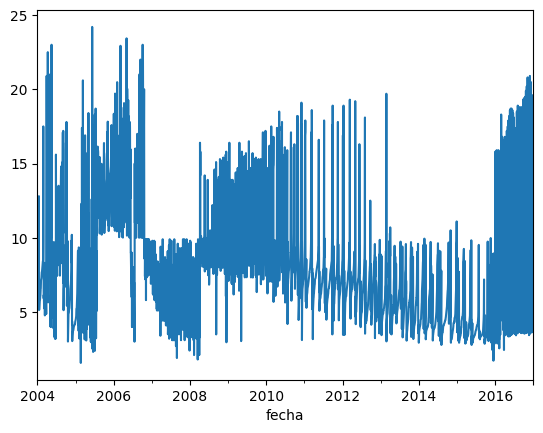

In [9]:
df1.plot()

El gráfico no muestra una tendencia clara a largo plazo. Se ven cambios bruscos de nivel en algunos años y periodos donde las subidas y bajadas son muy grandes, lo cual podría indicar valores atípicos o datos faltantes. Utilizando únicamente el gráfico no se puede asegurar que haya estacionalidad o no, debido al ruido y a los picos.

### 1.7
- Muestre el histograma de la variable series.
- ¿Qué conclusiones puede sacar del comportamiento de los datos?

<Axes: >

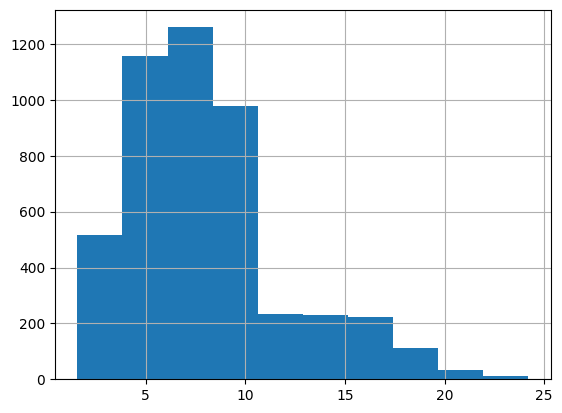

In [10]:
df1.hist()

El gráfico muestra que la distribución concentra la mayoría de los valores entre 5 y 10, generando una cola hacia la derecha que incluye algunos valores altos. Debido a esta cola la media probablemente sea superior a la mediana, así que utilizar únicamente el promedio podría dar la impresión de que los valores son más altos de lo que es típico.

### 1.8
- Agrupe los datos de la variable serie de manera Anual, y muestre los `boxplot` de cada año.
1. ¿Cómo se interpreta un gráfico `boxplot`?
2. ¿Qué conclusiones puede sacar del comportamiento de los datos?

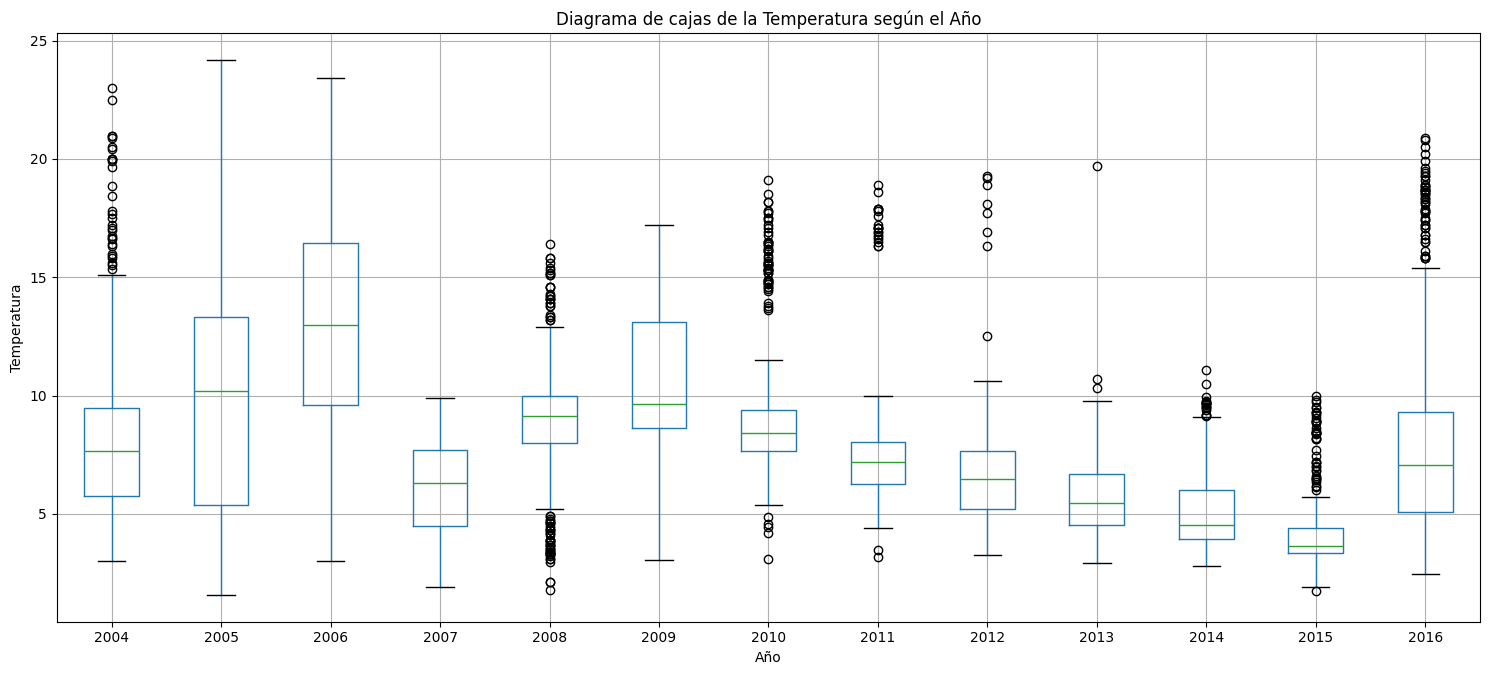

In [11]:
df1_yearly = df1.to_frame().assign(year=df1.index.year)

plt.figure(figsize=(15, 7))
df1_yearly.boxplot(column="temperatura", by="year", ax=plt.gca())
plt.title("Diagrama de cajas de la Temperatura según el Año")
plt.xlabel("Año")
plt.ylabel("Temperatura")
plt.suptitle("")
plt.tight_layout()
plt.show()

#### 1. ¿Cómo se interpreta un gráfico `boxplot`?

1. La _caja_ va de **Q1** (25%) a **Q3** (75%).
2. La altura de la _caja_ es el **IQR** o rango intercuartílico.
3. La línea que está dentro de la caja es la mediana (**Q2**).
4. Los bigotes llegan la valor más extremo en el rango de $[\text{Q1} - 1.5 \times \text{IQR}, \text{Q3} + 1.5 \times \text{IQR}]$.
5. Los puntos fuera de los bigotes son los posibles valores atípicos o _outliers_.

#### 2. ¿Qué conclusiones puede sacar del comportamiento de los datos?

- Entre 2004 a 2006 se ven niveles más altos y con mayor variabilidad.
- De 2007 a 2015 los niveles son más bajos con una dispersión menor.
- 2016 vuelve a tener niveles más altos y con mayor variabilidad.

### 1.9
- Muestre el Lag Scatter plot de la variable series.
    1. ¿Cómo se interpreta un Lag Scatter plot?
    2. ¿Qué conclusiones puede sacar del comportamiento de los datos?

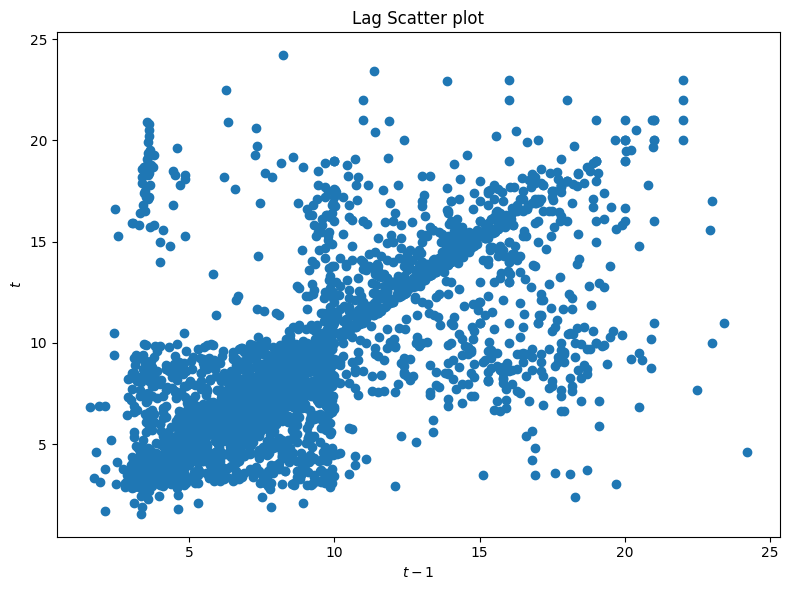

In [14]:
plt.figure(figsize=(8, 6))
lag_plot(df1, lag=1)
plt.title("Lag Scatter plot")
plt.xlabel("$t-1$")
plt.ylabel("$t$")
plt.tight_layout()
plt.show()

#### 1. ¿Cómo se interpreta un Lag Scatter plot?

- Cada punto compara un valor en $t-1$ con un valor en $t$ (para un _lag_ de 1).
- Una nube alargada en diagonal ascendente indica que hay una _autocorrelación positiva_ (valores consecutivos tienden a parecerse).
- Una nube casi circular sugiere poca correlación.
- Puntos alejados del grupo son posibles valores atípicos.

#### 2. ¿Qué conclusiones puede sacar del comportamiento de los datos?

Se observa una _autocorrelación positiva_ entre $t-1$ y $t$. La nube de puntos se alarga en sentido ascendente lo que indica una dependencia a corto plazo. En los valores bajos hay mucha concentración mientras que en valores altos la dispersión es mayor. También hay puntos alejados que son posibles valores atípicos.

### 1.10
- Muestre el gráfico autocorrelación de la variable series.
    1. ¿Cómo se interpreta este tipo de gráficos?
    2. ¿Qué conclusiones puede sacar del comportamiento de los datos?

<Figure size 1000x600 with 0 Axes>

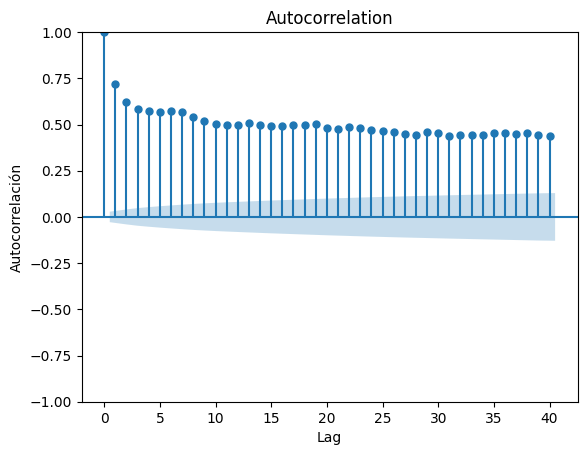

In [15]:
plt.figure(figsize=(10, 6))
plot_acf(df1, lags=40)
plt.xlabel("Lag")
plt.ylabel("Autocorrelación")
plt.show()

#### 1. ¿Cómo se interpreta este tipo de gráficos?

> [!IMPORTANT]
> TODO

#### 2. ¿Qué conclusiones puede sacar del comportamiento de los datos?

> [!IMPORTANT]
> TODO

# Parte 2. Diferenciación (15 puntos)

1. Luego, **utilizando el archivo `TS_d_2.csv`** realice la presente sección.
2. Complete en celdas de código y/o texto según convenga.
3. Documente bien su código.

### 2.1
- Cargue el archivo proporcionado y muestre los 10 primeros registros.

In [13]:
df2 = pd.read_csv("./data/TS_d_2.csv", index_col=0).iloc[:, 0].astype("float64")
df2.index = pd.to_datetime(df2.index, format="%d/%m/%Y")
df2.head(10)

fecha
2000-01-01    0.89
2000-02-01    0.86
2000-03-01    0.89
2000-04-01    0.83
2000-05-01    0.83
2000-06-01    0.85
2000-07-01    0.95
2000-08-01    0.89
2000-09-01    0.82
2000-10-01    0.72
Name: humedad, dtype: float64

### 2.2
- Aplique el Augmented Dickey-Fuller test, con una confianza estadística del 95% (por lo tanto un threshold del 0.05)
- Explique los resultados

In [14]:
dicker_fuller = cast(tuple[Any, ...], adfuller(df2))
print(f"""
ADF Statistic: {dicker_fuller[0]}
p-value: {dicker_fuller[1]}
Critical Values:
{"\n".join([f"\t{key}: {value:.3f}" for key, value in dicker_fuller[4].items()])}
""")


ADF Statistic: -6.069991800401613
p-value: 1.157025719501305e-07
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.573



#### Explicación

Con un nivel de confianza del 95% tenemos una muy alta certeza de que los datos son estacionarios debido a que el $p$-value es de $1.157025719501305e-07$ o $≈0.0000001157$. Lo cual es mucho menor a $0.05$.

Reforzando esto el _ADF Statistic_ es de $-6.069991800401613$ lo cual es mucho menor que el valores crítico al 5% ($–2.874$), por cual también tenemos una muy alta certeza de los que los datos son estacionarios.

Debido a esto rechazamos la hipótesis nula.

### 2.3
- Aplique la "Diferenciación" a la serie, y al resultado vuelva a aplicarle el Augmented Dickey-Fuller test, con una confianza estadística del 95% (por lo tanto un threshold del 0.05)
- Explique los resultados

Con el código a continuación estamos aplicando _diferenciación_ a la serie:

Utilizamos un _lag_ de 12 ya que los datos son mensuales.

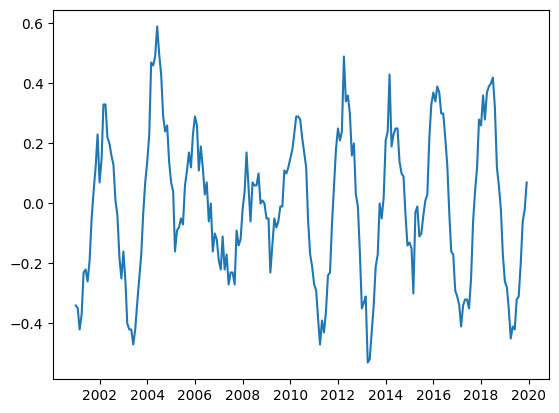

In [15]:
diff = df2.diff(12).dropna()

plt.plot(diff)
plt.show()

Con el código a continuación se aplica el _Augmented Dicker-Fuller test_:

In [16]:
dicker_fuller = cast(tuple[Any, ...], adfuller(diff))
print(f"""
ADF Statistic: {dicker_fuller[0]}
p-value: {dicker_fuller[1]}
Critical Values:
{"\n".join([f"\t{key}: {value:.3f}" for key, value in dicker_fuller[4].items()])}
""")


ADF Statistic: -3.406275485619014
p-value: 0.010746791995210688
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574



#### Explicación

Después de aplicar una diferenciación con $lag = 12$ aún rechazamos la hipótesis nula al 95% debido a que el $p$-value es menor al $0.05$ ($0.010746791995210688$) y el coeficiente estadístico _ADF_ ($-3.406275485619014$) es mucho menor al valor crítico al 5% de $-2.875$. Aún así antes esta misma conclusión se aplicaba al 99% el cual ahora no podría rechazar con certeza la hipótesis nula, lo cual nos podría decir que a pesar de todo esto ayuda un poco para que se elimine la estacionalidad de la serie.

### 2.4
- ¿Esta serie requería Diferenciación o no? Explique el gráfico generado, ¿por qué sé mira así relacionado con la necesidad o no de diferenciación?

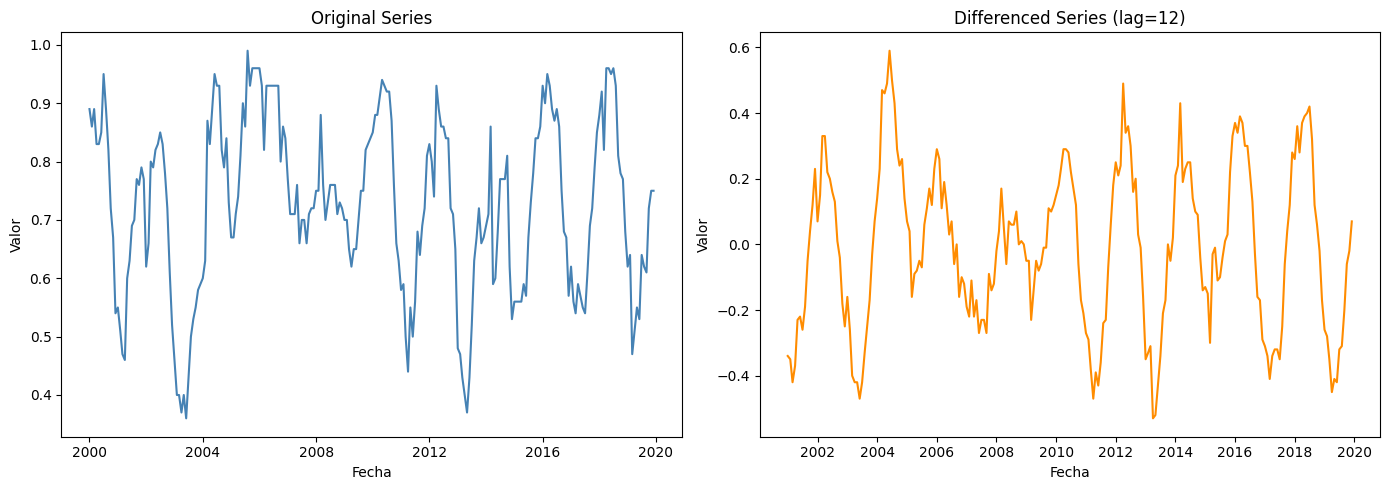

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(df2, color="steelblue")
axes[0].set_title("Original Series")
axes[0].set_xlabel("Fecha")
axes[0].set_ylabel("Valor")

axes[1].plot(diff, color="darkorange")
axes[1].set_title("Differenced Series (lag=12)")
axes[1].set_xlabel("Fecha")
axes[1].set_ylabel("Valor")

plt.tight_layout()
plt.show()

El propósito de la diferenciación es transformar una serie de tiempo no estacionaria en una que sí lo sea. Como nuestra serie de tiempo ya era estacionaria hacer uso de este proceso no era necesario, y más bien debilitó la señal de los datos.

# Parte 3.  ARIMA (15 puntos)

1. Luego, **utilizando el archivo `TS_d_3.csv`** realice la presente sección.
2. Complete en celdas de código y/o texto según convenga.
3. Documente bien su código.

### 3.1
- Explique en qué consiste ARIMA.

ARIMA es un acrónimo para la frase en inglés _AutoRegressive Integrated Moving Average_. Es utilizado para el análisis y predicción de series temporales. El acrónico de ARIMA es descriptivo, capturando los aspectos clave del modelo:

- **AR**: _AutoRegressive_. Es un modelo que utiliza las relaciones dependientes entre una observación y algún número de observaciones _lags_.
- **I**: _Integrated_. El uso de diferenciación de las observaciones para hacer que la serie de tiempo fuera estacionaria.
- **MA**: _Moving Average_. Es un modelo que utiliza la dependencia entre una observación y un error residual de un modelo _moving average_ aplicado a las observaciones con _lag_.

### 3.2
- Cargue el archivo y use los gráficos que considere prudente para ver cómo se comportan los datos
- Comente sus conclusiones

In [18]:
df3 = pd.read_csv("./data/TS_d_3.csv", index_col=0).iloc[:, 0].astype("float64")
df3.index = pd.to_datetime(df3.index, format="%d/%m/%Y")
df3 = df3.asfreq(pd.infer_freq(df3.index) or "D")
df3.describe()

count    4749.000000
mean        8.013887
std         3.863948
min         1.570000
25%         5.020000
50%         7.400000
75%         9.460000
max        24.200000
Name: temperatura, dtype: float64

<Axes: xlabel='fecha'>

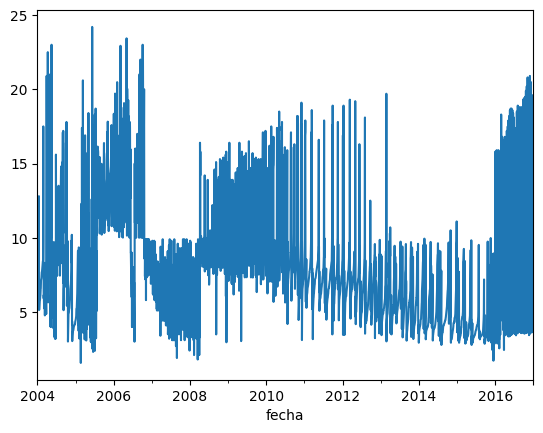

In [19]:
df3.plot()

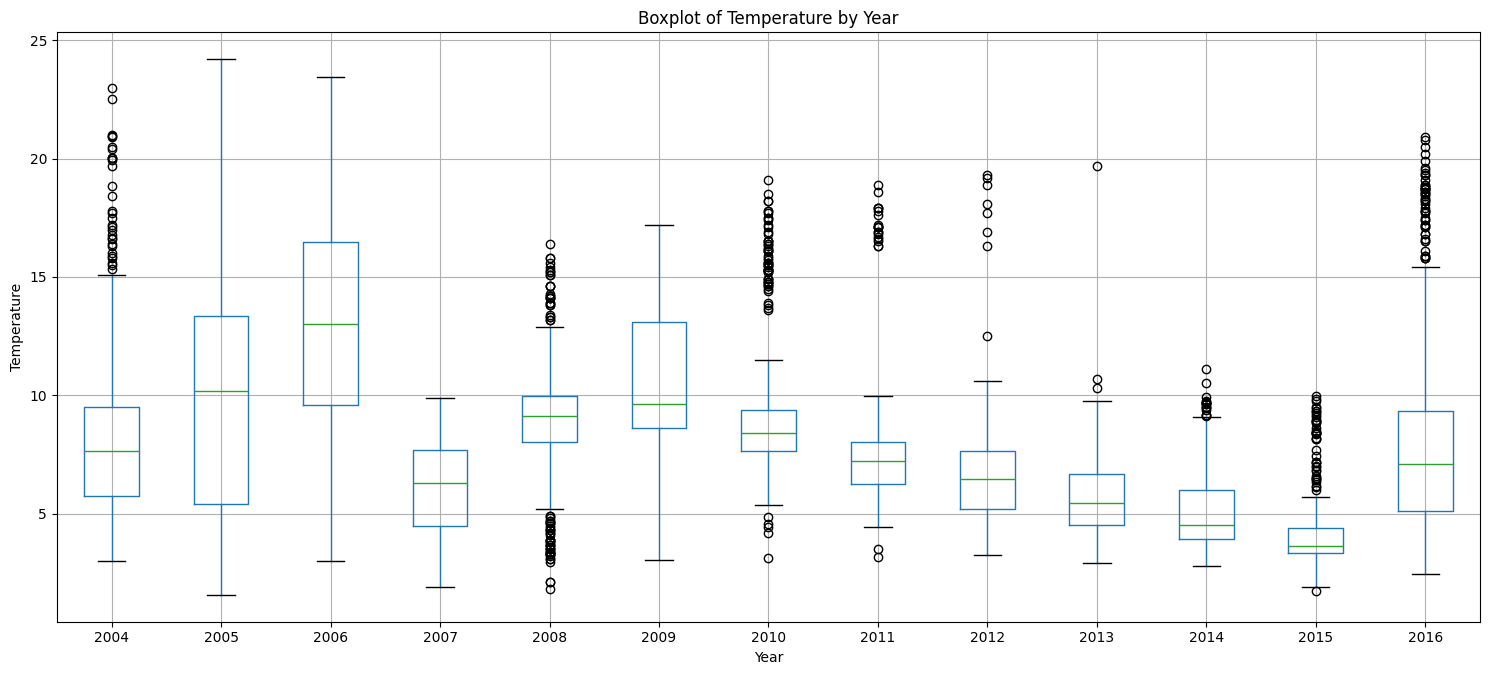

In [20]:
df3_yearly = pd.DataFrame(df3)
df3_yearly["year"] = cast(DatetimeIndex, df3_yearly.index).year

plt.figure(figsize=(15, 7))
df3_yearly.boxplot(column="temperatura", by="year", ax=plt.gca())
plt.title("Boxplot of Temperature by Year")
plt.xlabel("Year")
plt.ylabel("Temperature")
plt.suptitle("")
plt.tight_layout()
plt.show()

In [13]:
plt.figure(figsize=(10, 6))
plot_acf(df3, lags=40)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

NameError: name 'df3' is not defined

<Figure size 1000x600 with 0 Axes>

#### Conclusiones

En base a los datos y gráficos anteriores podemos concluir preliminarmente que la serie no parece ser estacionaria. Esto debido a que la media cambia por periodos y la varianza también. Algunos años tienen alta dispersión y otros son más estables.

También se puede ver que hay autocorrelación (los datos actuales dependen fuertemente de los pasados).

Hay también años con outliers recurrentes. Hay años con temperaturas extremas que sobresalen del patrón normal.

### 3.3
- Analice si requiere hacer diferenciación o no. Explique

Debido a lo que observamos en los gráficos anteriores se requiere hacer diferenciación ya que la serie no parece ser estacionaria.

### 3.4
- Haga forecast (similar a las últimas secciones de ese capítulo), con un train de 80% y un test de 20% (no olvide que son series temporales, no datos i.i.d.)

Test RMSE: 4.191


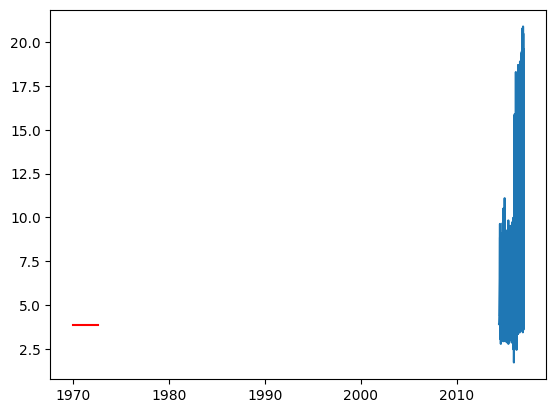

In [ ]:
size = int(len(df3) * 0.8)
train, test = df3.iloc[:size], df3.iloc[size:]
history = list(train)
predictions = list()
for obs in test:
    model = ARIMA(train, order=(5, 1, 0))
    output: Series = model.fit().forecast()
    yhat = output.iloc[0]
    predictions.append(yhat)
    history.append(obs)
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(test, predictions))
print(f"Test RMSE: {rmse:.3f}")
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color="red")
plt.show()

### 3.5
- Grafique el predicho versus el real y comente sus conclusiones.

<Figure size 1000x600 with 0 Axes>

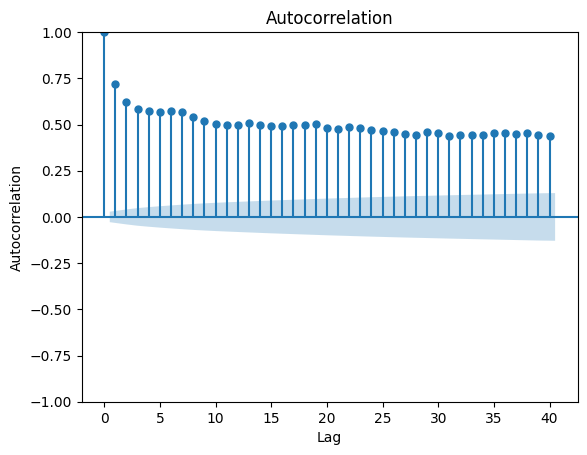

# Parte 4.  Regresión lineal y breve diseño experimental (20 puntos)

**Se le suministra un archivo llamado `TS_d_3.csv`**.

### 4.1
- Cargue el archivo en el orden en que vienen los datos y solo deje la columna temperatura.
- Muestre cuántas filas tiene el conjunto de datos.

### 4.2
- Como es solo una serie temporal, divida entre X_train y X_test (70% y 30%). Note que por ahora no tiene y (ni y_train, ni y_test)
- Muestre los tres primeros registros.

fecha
2004-01-01    5.3
2004-01-02    5.6
2004-01-03    5.9
2004-01-04    6.2
2004-01-05    8.4
Name: temperatura, dtype: float64

### 4.3
- Como todos los valores están en la misma escala y por si desea comprar el resultado con el ARIMA, no escale los datos. Ahora bien, entendiendo lo dicho anteriormente, puede escalar el X_train y X_test utilizando MinMaxScaler (pero cuidado al interpretar valores como el MSE).
- Indique qué decisión tomó y por qué.
- Muestre los tres primeros registros.

pandas.core.series.Series

### 4.4
- Utilizando la técnica de Lag Features, procese tanto el train como el test con los valores y un Lag=5 y ahora si va tener y_train y y_test, pues serán el siguiente periodo a predecir.
- Muestre los tres primeros registros de cada uno.


promedio: 8.013887134133503
mediana: 7.4
varianza: 14.93009508077167
desviación estandar: 3.8639481208695945



### 4.5
- Vamos ahora a utilizar `sklearn` para calcular los pesos.
- Utilizando algún algoritmo de regresión de la biblioteca `sklearn` ajuste el modelo y calcule $y_{pred}$, calcule las métricas $R2$ y $MSE$ entre el $y_{pred}$ y el $y_{test}$.
- Comente los resultados obtenidos

# Parte 5.  Uso de biblioteca Prophet (15 puntos)

**Se le suministra un archivo llamado `trainV.csv`**.

Estudie el código que se le proporciona, luego busque otra serie temporal y aplique un proceso similar.

In [ ]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
# Mostrar los gráficos integrados dentro de jupyter notebook
%matplotlib inline

In [ ]:
from prophet import Prophet

In [ ]:
# incluir el enlace completo al archivo csv que contiene tu conjunto de datos
sales_df = pd.read_csv("trainV.csv", parse_dates=["Date"], dayfirst=True)
sales_df = sales_df[["Date", "Sales"]].rename(columns={"Date": "ds", "Sales": "y"})

print(sales_df.size)
print(sales_df.head(20))

1562
           ds     y
0  2013-01-02  5530
1  2013-01-03  4327
2  2013-01-04  4486
3  2013-01-05  4997
4  2013-01-07  7176
5  2013-01-08  5580
6  2013-01-09  5471
7  2013-01-10  4892
8  2013-01-11  4881
9  2013-01-12  4952
10 2013-01-14  4717
11 2013-01-15  3900
12 2013-01-16  4008
13 2013-01-17  4044
14 2013-01-18  4127
15 2013-01-19  5182
16 2013-01-21  5394
17 2013-01-22  5720
18 2013-01-23  5578
19 2013-01-24  5195


In [ ]:
# Split: últimos x como test
horizon = 300
train = sales_df.iloc[:-horizon].copy()
test = sales_df.iloc[-horizon:].copy()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvd_5_79a/xp_tlepx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpvd_5_79a/n0za3_u6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83948', 'data', 'file=/tmp/tmpvd_5_79a/xp_tlepx.json', 'init=/tmp/tmpvd_5_79a/n0za3_u6.json', 'output', 'file=/tmp/tmpvd_5_79a/prophet_modeljfhzawtw/prophet_model-20250911040716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:07:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:07:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE:   785.93
RMSE:  1036.902
MAPE:  16.84 %


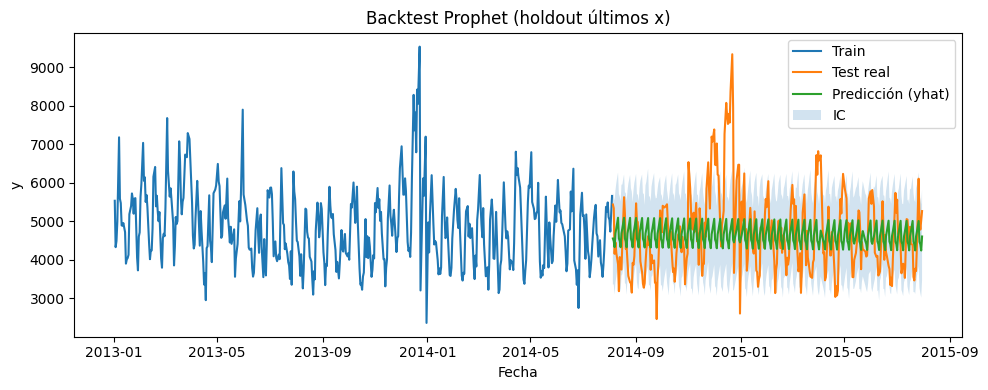

In [ ]:
m = Prophet(
    growth="linear",
    yearly_seasonality=False,
    weekly_seasonality="auto",
    daily_seasonality="auto",
    seasonality_mode="additive",
    changepoint_prior_scale=0.05,
)
m.fit(train)

# %%
# Predecir para EXACTAMENTE las fechas del test (sin generar futuro extra)
future_test = test[["ds"]].copy()
forecast_test = m.predict(future_test)

# %%
# Comparar real vs. predicho y calcular métricas
comp = test.merge(forecast_test[["ds", "yhat", "yhat_lower", "yhat_upper"]], on="ds", how="left")


def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))


def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))


def mape(y_true, y_pred):
    # Evita división por cero; ajusta a tu caso si hay ceros
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    eps = 1e-8
    return np.mean(np.abs((y_true - y_pred) / (np.maximum(np.abs(y_true), eps)))) * 100


print("MAE:  ", round(mae(comp["y"], comp["yhat"]), 3))
print("RMSE: ", round(rmse(comp["y"], comp["yhat"]), 3))
print("MAPE: ", round(mape(comp["y"], comp["yhat"]), 2), "%")

# %%
# Gráfico simple de real vs. predicho (matplotlib)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(train["ds"], train["y"], label="Train")
plt.plot(comp["ds"], comp["y"], label="Test real")
plt.plot(comp["ds"], comp["yhat"], label="Predicción (yhat)")
plt.fill_between(comp["ds"], comp["yhat_lower"], comp["yhat_upper"], alpha=0.2, label="IC")
plt.legend()
plt.title("Backtest Prophet (holdout últimos x)")
plt.xlabel("Fecha")
plt.ylabel("y")
plt.tight_layout()
plt.show()

### 5.1 Comente las principales conclusiones que obtiene luego de aplicar esta biblioteca a la serie temporal que Usted proporcionó
